<a id="content"></a>
# Contents:
1. 
2. [Считаем lifetime через MRC](#calc-mrc)
2. [Извлекаем фрагменты. Замена на константу](#method1)
3. [Извлекаем фрагменты. Сглаживание](#method2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import bisect

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [2]:
data = pd.read_csv('data/DeBilt.dat', '\s+')
data.columns = ["year", "month", "day", "val"]

In [3]:
data

year  month  day  val
0      1901      1    3  0.0
1      1901      1    4  0.0
2      1901      1    5  3.6
3      1901      1    6  6.1
4      1901      1    7  2.8
...     ...    ...  ...  ...
43615  2020      7    2  5.7
43616  2020      7    3  7.4
43617  2020      7    4  0.1
43618  2020      7    5  4.0
43619  2020      7    6  6.9

[43620 rows x 4 columns]

All tests passed


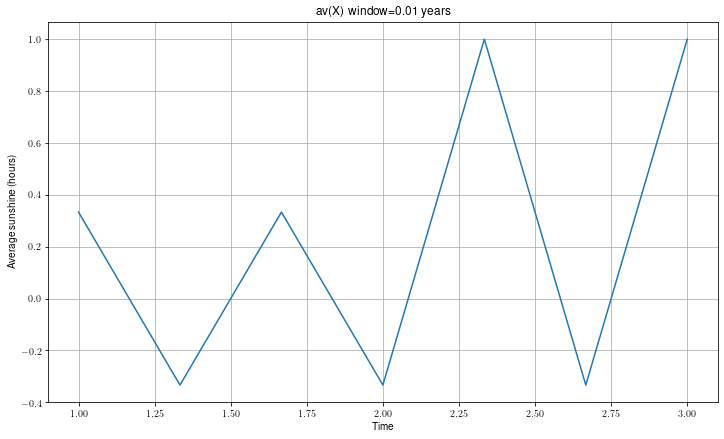

In [5]:
def build_averaged_values_arr(arr, window_size):
    n = len(arr)
    av = np.zeros(n)
    cur_sum = sum(arr[:window_size - 1])
    for i in range(window_size - 1, n):
        cur_sum += arr[i]
        if i - window_size >= 0:
            cur_sum -= arr[i - window_size]
        av[i] = cur_sum / window_size
    return av

def build_averaged_values(df, window_size):
    n = df.shape[0]
    av = np.zeros(n)
    cur_sum = sum(df.loc[:window_size - 2, 'val'])
    for i in range(window_size - 1, n):
        cur_sum += df.loc[i, 'val']
        if i - window_size >= 0:
            cur_sum -= df.loc[i - window_size, 'val']
        av[i] = cur_sum / window_size
    return av

def __test_build_averaged_values():
    df = pd.DataFrame({
        'val': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    })
    window_size = 3
    eps = 10**(-5)
    averaged = build_averaged_values(df, 3)
    assert len(averaged) == 10, "wrong size of average array"
    assert abs(averaged[0]) < eps, 'incorrect average, elem 0'
    assert abs(averaged[2] - 2) < eps, 'incorrect average, elem 2 is ' + str(averaged[2])
    assert abs(averaged[9] - 9) < eps, 'incorrect average, elem 9'
        
def eq(x, y):
    eps = 10**(-5)
    return abs(x - y) < eps
    
def build_derivatives(df):
    #df['averaged_values'] = build_averaged_values(df, window_size)
    n = df.shape[0]
    deriv = np.zeros(n)
    for i in range(1, n):
        if 'year' not in df or df.loc[i, 'year'] == df.loc[i - 1, 'year']:
            deriv[i] = df.loc[i, 'val'] - df.loc[i - 1, 'val']
    return deriv

def __test_build_derivatives():
    df = pd.DataFrame({
        'val':  [1, 4, 9, 16, 25, 36, 49, 64, 81, 100],
        'year': [0, 0, 0,  0,  1,  1,  1,  1,  1,    1]
    })
    window_size = 3
    #avs = [0, 0, 14/3, 29/3, 50/3, 77/3, 110/3, 149/3, 194/3, 245/3]
    expected = [0, 3, 5, 7, 0, 11, 13, 15, 17, 19]
    actual = build_derivatives(df)
    for i in range(10):
        assert eq(expected[i], actual[i]), "derivative at i=" + str(i) + " is incorrect " + "actual=" + str(actual[i])+" expected=" + str(expected[i])
    

def build_relation(df, window_size):
    averaged_values = build_averaged_values(df, window_size)[window_size:]
    derivatives = np.abs(build_derivatives(df))[1:]
    average_derivatives = build_averaged_values_arr(derivatives, window_size)[window_size - 1:]
    # TODO : add some null checks and processing
    n = df.shape[0]
    result = np.zeros(n)
    result[window_size:] = averaged_values / average_derivatives
    return result

def __test_build_relation():
    df = pd.DataFrame({
        'val': [1, -1, 1, -1, 1, -1, 3, -3, 3]
    })
    window_size=3
    #avs = [0, 0, 1/3, -1/3, 1/3, -1/3, 1, -1/3, 1]
    #der = [0, 2,   2,    2,   2,    2,  4,   6,  6]
    #avder=[0, 0,   0,    2,   2,    2,8/3,   4, 16/3]
    expected = [0, 0, 0, -1/6, 1/6, -1/6, 3/8, -1/12, 3/16]
    actual = build_relation(df, window_size)
    for i in range(9):
        assert eq(expected[i], actual[i]), "relation at i=" + str(i) + " is incorrect " + "actual=" + str(actual[i])+" expected=" + str(expected[i])
    
    
def make_dates(df):
    transformer = lambda dt: datetime.date(int(dt['year']), int(dt['month']), int(dt['day'])).toordinal() 
    df['date_in_days'] = df.apply(transformer, axis=1)

def plot_relation(df, window_size):
    df['relation'] = build_relation(df, window_size)
    plt.figure(figsize=(12, 7))
    plt.grid(True)
    s = r'$Y(t) = \frac{X_T(t)}{\dot{X}_T(t)}$'
    s += " window=" + "{:.2f}".format(window_size/365) + " years"
    plt.title(s, fontsize=18)
    plt.xlabel('Time')
    plt.ylabel('Relation')
    n = df.shape[0]
    years = np.linspace(df.loc[window_size, 'year'], df.loc[n - 1, 'year'], n - window_size)
    plt.plot(years, df.loc[window_size:, 'relation'])
    
def __test_plot_relation():
    df = pd.DataFrame({
        'val': [1, -1, 1, -1, 1, -1, 3, -3, 3],
        'year': [1, 1, 1, 1, 2, 2, 2, 2, 3]
    })
    plot_relation(df, 3)
    
def plot_average(df, window_size):
    average = build_averaged_values(df, window_size)
    plt.figure(figsize=(12, 7))
    plt.grid(True)
    plt.title('av(X) window=' + "{:.2f}".format(window_size/365) + " years")
    plt.xlabel('Time')
    plt.ylabel('Average sunshine (hours)')
    n = df.shape[0]
    years = np.linspace(df.loc[window_size - 1, 'year'], df.loc[n - 1, 'year'], n - window_size + 1)
    plt.plot(years, average[window_size-1:])

    
def __test_plot_average():
    df = pd.DataFrame({
        'val': [1, -1, 1, -1, 1, -1, 3, -3, 3],
        'year': [1, 1, 1, 1, 2, 2, 2, 2, 3],
        'month': [4, 4, 4, 4 ,4 ,4, 4, 4, 4]
    })
    plot_average(df, 3)
    
def plot_deriv(df, window_size):
    deriv = abs(build_derivatives(df, window_size))
    plt.figure(figsize=(12, 7))
    plt.grid(True)
    plt.title('|av\'(X)| window=' + "{:.2f}".format(window_size/365) + " years")
    plt.xlabel('Time')
    plt.ylabel('Abs of derivative')
    n = df.shape[0]
    years = np.linspace(df.loc[window_size, 'year'], df.loc[n - 1, 'year'], n - window_size)
    plt.plot(years, deriv[window_size:])
    
def test_all():
    __test_build_averaged_values()
    __test_build_derivatives()
    __test_build_relation()
    __test_plot_relation()
    __test_plot_average()
    print("All tests passed")
    
test_all()

Модель с модулированным шумом:
\begin{align}
& X(t) = \eta(t)\sin(wt)+c \\
& \eta(t) = \alpha\eta(t - 1) + \xi(t) \\
& \xi \sim U(0, 1) \\
\end{align}

\begin{align}
& X'(t) = x_t - x_{t-1} \\
& \dot{X}_T(t) = X'_T(t) = \dfrac{1}{T} \sum_{i = t - T + 1}^t |X'(i)|\\
& X_T(t) = \dfrac{1}{T}\sum_{i = t - T + 1}^tx_i \\
& Y(t) = \dfrac{X_T(t)}{|X'_T(t)|} \approx \dfrac{1}{1 - \alpha}
\end{align}

In [36]:
plot_relation(data, window_size=365)

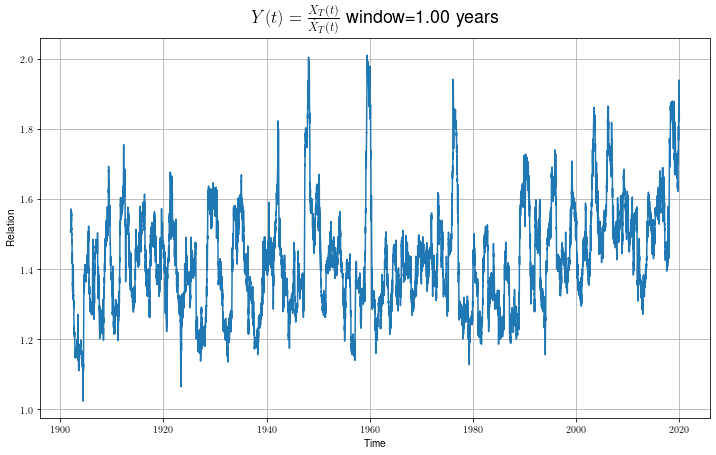

In [6]:
plot_relation(data, window_size=365)

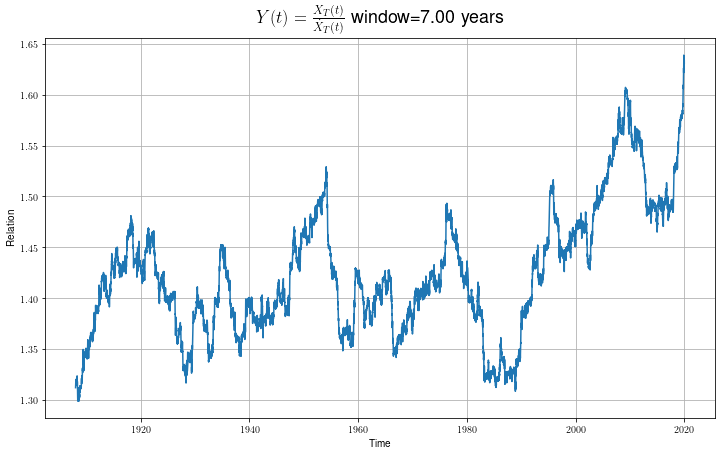

In [7]:
# 7 years 
plot_relation(data, window_size=7*365)

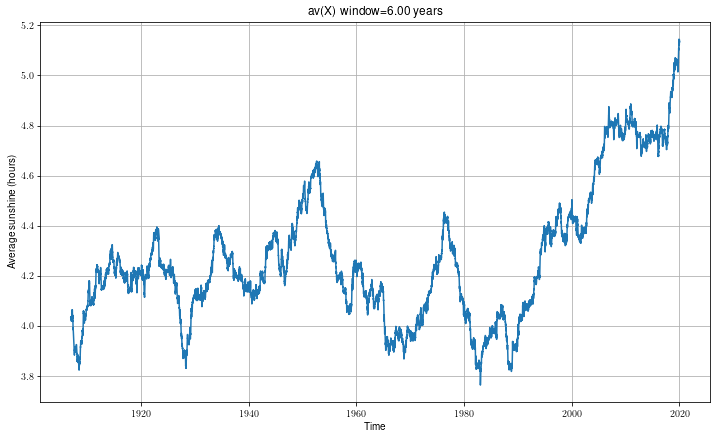

In [8]:
plot_average(data, 365*6)

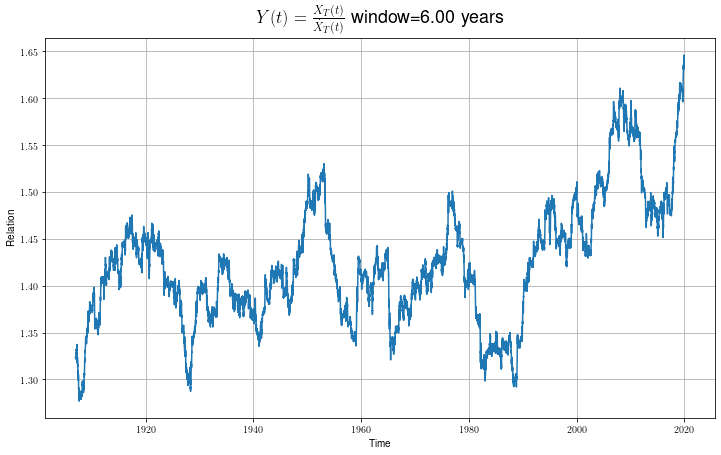

In [40]:
plot_relation(data, 365*6)

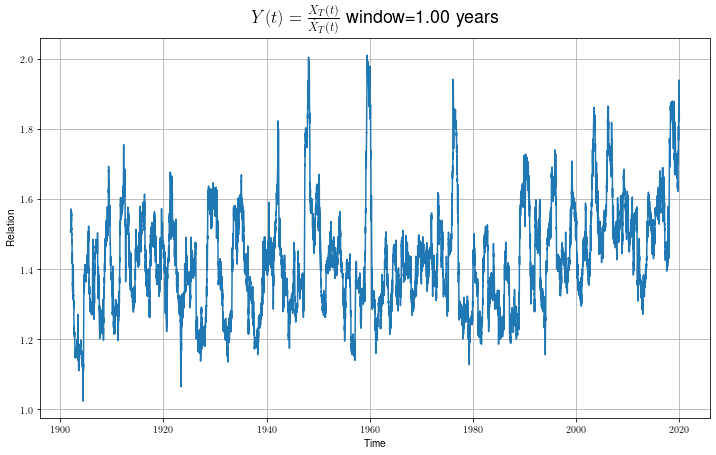

In [170]:
plot_relation(data, 365)

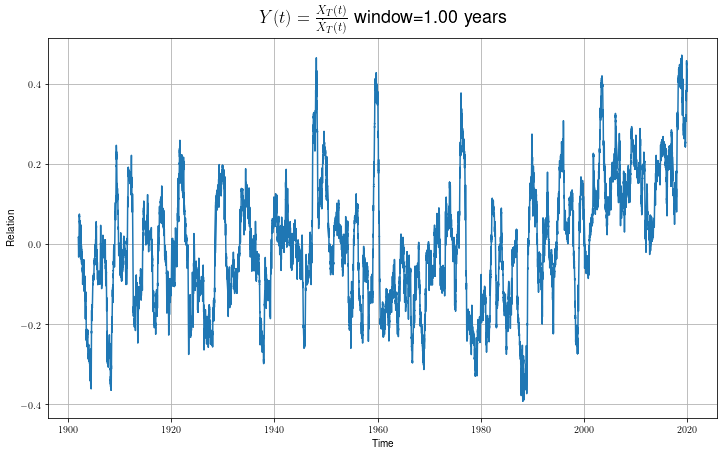

In [168]:
plot_relation(data, 365)

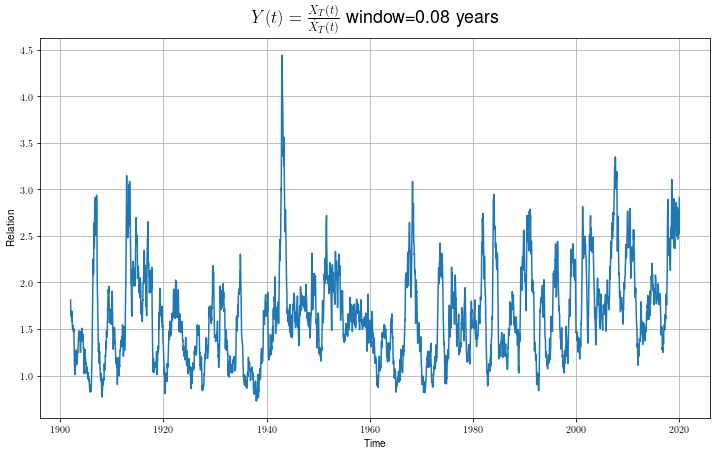

In [9]:
df_april = data[data['month']==4]
df_april = df_april.reset_index(drop=True)
plot_relation(df_april, 30)

In [10]:
df_october = data[data['month']==10]
df_october = df_october.reset_index(drop=True)
plot_relation(df_october, 30)

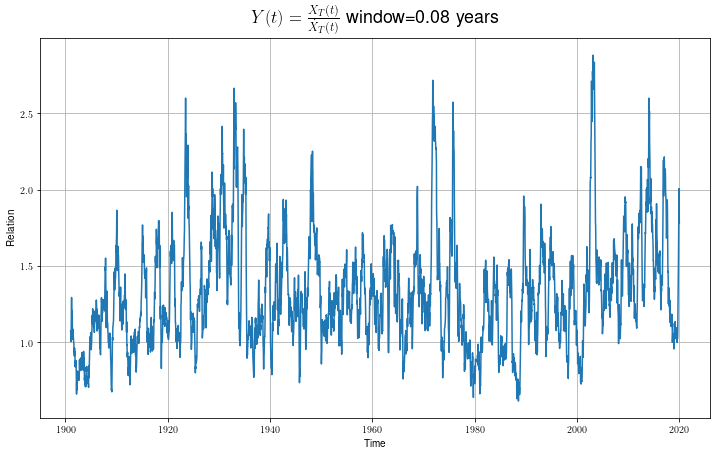

In [47]:
df_march = data[data['month']==3]
df_march = df_march.reset_index(drop=True)
plot_relation(df_march, 30)

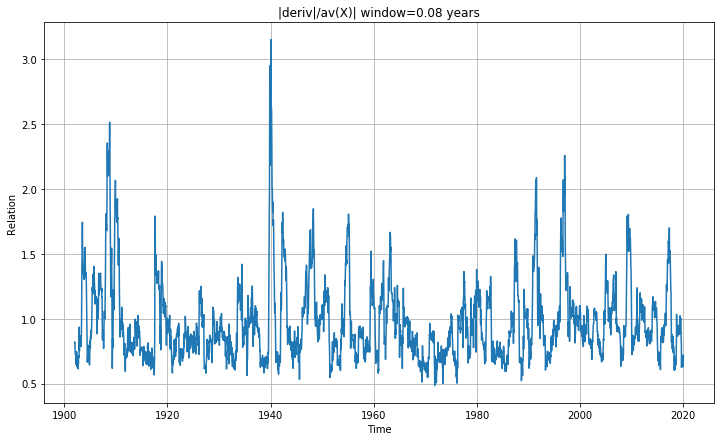

In [73]:
df_march = data[data['month']==1]
df_march = df_march.reset_index(drop=True)
plot_relation(df_march, 30)

<a id='calc-mrc'></a>
## Считаем MRC

1. Находим среднее $M$, берем его за значение для отсечения
2. Выбираем какое-то окно длины $k$. Отображаем исходную последовательнось в бинарные последовательности длины $k$. 
$$x_i \rightarrow F(i) = I[x_i > $M$]$$
$$F_k(n) := \left[F(n), \dots , F(n + k - 1) \right]$$

[Содержание](#content)

In [20]:
SUNNY_THRESHOLD = 2

In [20]:
def get_binary_map(arr):
    _mean = SUNNY_THRESHOLD#np.mean(data['val'])
    arr = np.array(arr)
    arr -= _mean
    signs = arr >= 0
    return signs
    
def __test_get_binary_map():
    arr = [1, 2, 3, 4, 5, 6]
    bins = get_binary_map(arr)
    expected = [False, False, False, True, True, True]
    for i in range(6):
        assert bins[i] == expected[i], "invalid binary_map i=" + str(i) + " expected=" + str(expected[i]) + " actual=" + str(bins[i])
    

# we suppose that arr contains binary strings of the same
def get_entropy(arr):
    counter = {}
    for bin_str in arr:
        if bin_str in counter:
            counter[bin_str] += 1
        else:
            counter[bin_str] = 1
    entr = 0
    for k, v in counter.items():
        prob = v / len(arr)
        entr -= math.log(prob, 2) * prob
    return entr

def get_entropy2(arr):
    counter = {}
    counter1 = [0, 0]
    n = len(arr)
    for i in range(0, n - 1):
        s = (arr[i], arr[i+1])
        if s not in counter:
            counter[s] = 1
        else:
            counter[s] += 1
        counter1[int(arr[i])] += 1
    entr = 0
    for k, v in counter.items():
        prob = v / len(arr)
        entr -= math.log(prob, 2) * prob
    for v in counter1:
        prob = v / (len(arr) - 1)
        if prob > 0:
            entr += math.log(prob, 2) * prob
            
    return entr


def __test_get_entropy():
    s1 = "01"
    s2 = "10"
    s3 = "11"
    s4 = "00"
    arr = [s1, s2, s3, s3]
    entr = get_entropy(arr)
    # -1/4 ln(1/4) * 2 - 1/2 * ln(1/2) = ln 2 + 1/2 ln(2)
    
    expected = 3/2 * math.log(2, 2)
    assert eq(entr, expected), "expected=" + str(expected) + " actual=" + str(entr)
    
def __test_get_entropy2():
    s1 = "01"
    s2 = "10"
    s3 = "11"
    s4 = "00"
    arr = [s1, s2, s3, s3]
    s = "01110"
    entr = get_entropy(arr)
    # -1/4 ln(1/4) * 2 - 1/2 * ln(1/2) = ln 2 + 1/2 ln(2)
    
    expected = 3/2 * math.log(2, 2)
    assert eq(entr, expected), "expected=" + str(expected) + " actual=" + str(entr)



def test_all():
    __test_get_binary_map()
    __test_get_entropy()
    #__test_get_entropy2()
    print("all passed")


#test_all()

$E(n) = -\sum\limits_{i=1}^{2^n} p_i \log p_i$ --- энтропия бинарной строки из $n$ символов
\begin{align}
S(p, a) = E(n + 1) - E(n) = E(2) - E(1)
\end{align}
Энтропия растет линейно с увеличением длины строки.
Пусть первый символ строки равен единице с вероятностью $p$ и нулю с вероятностью $1-p$. Далее, каждый следующий символ равен предыдущему с вероятностью $a$. С вероятностью $1-a$ следующий символ будет выбран независимо от предыдущего (с вероятностью. $p$ будет 1, с $1-p$ будет 0).

Путем бумажки и ручки можно вывести, что:
\begin{align}
& S(p, 1 - a) = S(p, \varepsilon) =\\
& = p(1-p)\varepsilon \left( 2\log \varepsilon + \log p + \log (1-p) \right) + \\
& + p(1 - \varepsilon + p\varepsilon)\log (1 - \varepsilon + p\varepsilon) + \\
& + (1-p)(1-p\varepsilon)\log(1 - p\varepsilon)
\end{align}

\begin{align}
&
\end{align}

In [21]:
def get_slope_entropy(p, k=100):
    eps = np.linspace(0.01, 1, k)
    slope = []
    for e in eps:
        s = p * (1 - p) * e * (2 * math.log(e, 2) + math.log(p, 2) + math.log(1-p, 2))
        s+= p * (1 - e + p * e) * math.log(1 - e + p * e, 2)
        s+= (1 - p) * (1 - p * e) * math.log(1 - p * e, 2)
        slope.append(-s)
    return eps, slope

def plot_slope_entropy(ps):
    plt.figure(figsize=(12,7))
    plt.grid(True)
    plt.title("Entropy Slope")
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("Entropy of the map " + r'$B(n) \rightarrow B(n+1)$')
    plt.xlabel(r'$\varepsilon = 1 - \alpha$' + " correlation param", fontsize=16)

    for p in ps:        
        eps, slope = get_slope_entropy(p)
        plt.plot(eps, slope, label=str(p))
        a, b = np.polyfit(np.log(eps), np.log(slope), 1)
        print('Coeff: ', a, b)
    
    plt.legend(list(map(lambda p: str(int(p * 1000) / 1000), ps)))

In [22]:
GLOBAL_REFER_EPS = []
GLOBAL_REFER_ENTROPY = []
GLOBAL_REFER_P = np.linspace(0.01, 1, 1000, endpoint=False)
for p in GLOBAL_REFER_P:
    _eps, _entr = get_slope_entropy(p)
    GLOBAL_REFER_EPS.append(_eps)
    GLOBAL_REFER_ENTROPY.append(_entr)

Coeff:  0.7563124339590191 -2.408996686197102
Coeff:  0.6743524129479654 -0.5496179373425902
Coeff:  0.6485154031305967 -0.14460388186287865
Coeff:  0.6349114631623908 0.047262707120172456
Coeff:  0.6279765435208038 0.14024843053207448
Coeff:  0.6259587589371576 0.16673698382463162
Coeff:  0.6284380649110787 0.13415466985732943
Coeff:  0.6359356625355592 0.03326558521677922
Coeff:  0.6504089229932065 -0.17238175818086154
Coeff:  0.6782357331496588 -0.6158529550678354


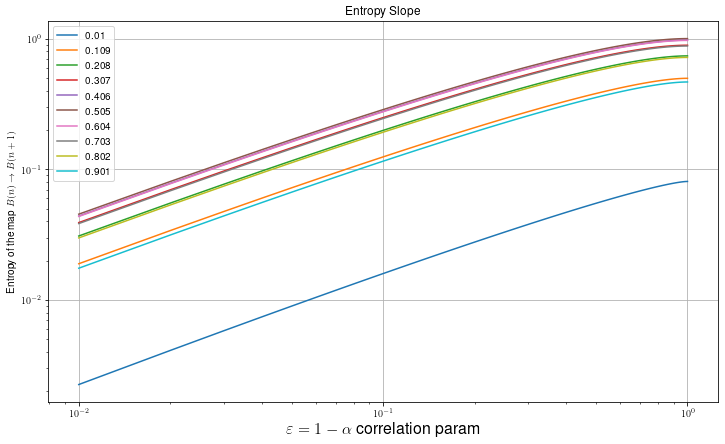

In [23]:
plot_slope_entropy(np.linspace(0.01, 1, 10, endpoint=False))

Coeff:  0.7563124339590191 -2.408996686197102
Coeff:  0.6743524129479654 -0.5496179373425902
Coeff:  0.6485154031305967 -0.14460388186287865
Coeff:  0.6349114631623908 0.047262707120172456
Coeff:  0.6279765435208038 0.14024843053207448
Coeff:  0.6259587589371576 0.16673698382463162
Coeff:  0.6284380649110787 0.13415466985732943
Coeff:  0.6359356625355592 0.03326558521677922
Coeff:  0.6504089229932065 -0.17238175818086154
Coeff:  0.6782357331496588 -0.6158529550678354


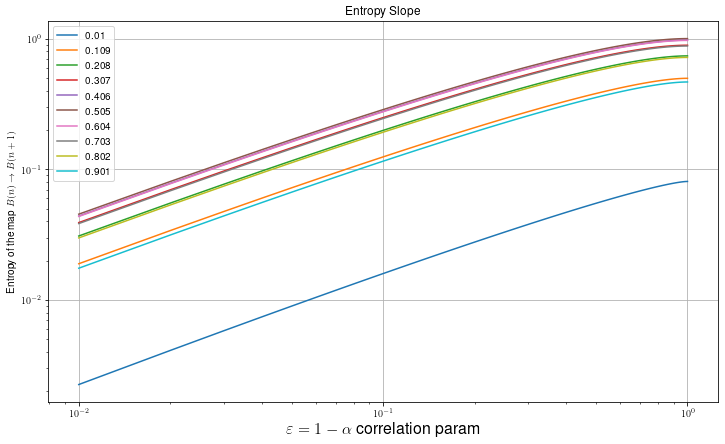

In [47]:
plot_slope_entropy(np.linspace(0.01, 1, 10, endpoint=False))

In [26]:
def get_exper_entropy(arr, window):
    n = len(arr)
    res = []
    for i in range(window - 1, n):
        arr_ = get_binary_map(arr[i-window+1:i+1])
        e = get_entropy2(arr_)
        res.append(e)
    return res

def plot_exper_entropy(df, window):
    entropy = get_exper_entropy(df['val'].tolist(), window)
    plt.figure(figsize=(12,7))
    plt.grid(True)
    plt.title('Experimental entropy, window=' + str(window))
    plt.ylabel('Entropy')
    plt.xlabel('time')
    n = len(entropy)
    years = np.linspace(df.loc[window-1, 'year'], df.loc[n-1, 'year'], n)
    plt.plot(years, entropy)
    


In [129]:
df = data[data['month']==4]
df = df.reset_index(drop=True)
plot_exper_entropy(df, 30)

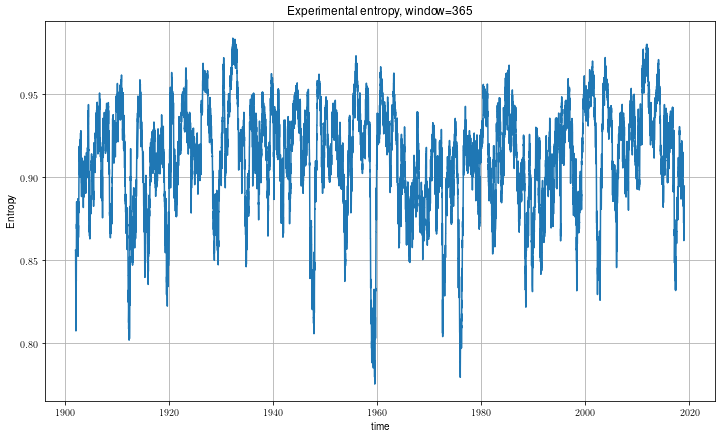

In [130]:
plot_exper_entropy(data, 365)

In [24]:
def find_eps(entropy_exp):
    ans = 0
    for _eps, _entr in zip(GLOBAL_REFER_EPS, GLOBAL_REFER_ENTROPY):
        idx = bisect.bisect(_entr, entropy_exp)
        n = len(_eps)
        ans += math.log(_eps[min(n - 1, idx)])
    ans /= len(GLOBAL_REFER_EPS)
    ans = math.exp(ans)
    return ans

def find_lifetime(entropy_exp):
    eps = find_eps(entropy_exp)
    return 1/eps

def get_lifetimes(df, window):
    arr = df['val'].tolist()
    entropys = get_exper_entropy(arr, window)
    lf = []
    for entr in entropys:
        lf.append(find_lifetime(entr))
    return lf

def plot_lifetimes(df, window):
    lifetimes = get_lifetimes(df, window)
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    plt.figure(figsize=(12, 7))
    plt.title('Lifetime, window=' + str(window))
    plt.xlabel('Date')
    plt.ylabel('Lifetime')
    plt.grid(True)
    plt.plot(dates, lifetimes)
    
def plot_all(df, window, corr_window=365):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(14)
    fig.set_figheight(10)
    ax1.grid(True)
    ax2.grid(True)
    ax1.set_title('Lifetimes: both methods')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Lifetime')
    lifetimes = get_lifetimes(df, window)
    relation = build_relation(df, window)
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    n = df.shape[0]
    years = np.linspace(df.loc[window - 1, 'year'], df.loc[n - 1, 'year'], n - window)
    ax1.plot(years, relation[window:], label='By derivative')
    ax1.plot(dates, lifetimes, label='By entropy')
    s1 = pd.Series(relation[window:])
    s2 = pd.Series(lifetimes)
    corr = s1.rolling(corr_window).corr(s2)
    ax2.plot(years[corr_window - 1:], corr[corr_window : ], label='corrcoeff', color='tab:red')
    ax1.legend()
    ax2.legend()
    
def plot_all3(df, window, corr_window=365, predicate=lambda x: True):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_figwidth(14)
    fig.set_figheight(10)
    ax1.grid(True)
    ax2.grid(True)
    ax1.set_title('Lifetimes: both methods')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Lifetime')
    mask = df['month'].apply(predicate)
    lifetimes = np.array(get_lifetimes(df, window)[1:])
    mask = np.array(mask[window:])
    lifetimes = lifetimes[mask]
    relation = build_relation(df, window)[window:]
    dates = df.loc[window:, 'year'].tolist()
    relation = relation[mask]
    dates = np.linspace(dates[0], dates[-1], len(lifetimes))
    n = df.shape[0]
    years = np.linspace(df.loc[window - 1, 'year'], df.loc[n - 1, 'year'], len(relation))
    ax1.plot(years, relation, label='By derivative')
    ax1.plot(dates, lifetimes, label='By entropy')
    s1 = pd.Series(relation)
    s1_smooth = s1.rolling(365).mean()
    s2 = pd.Series(lifetimes)
    s2_smooth = s2.rolling(365).mean()
    corr = s1_smooth.rolling(corr_window).corr(s2_smooth)
    ax3.plot(years[:s1_smooth.size], s1_smooth, label='By derivative')
    ax3.plot(dates[:s2_smooth.size], s2_smooth, label='By entropy')
    ax2.plot(years[365 + corr_window:], corr[365+ corr_window : ], label='corrcoeff', color='tab:red')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
def plot_all_means(df, window):
    mean_window = 365
    lifetimes = get_lifetimes(df, window)
    m = len(lifetimes)
    lifetimes_means = np.zeros(m)
    for i in range(mean_window, m):
        lifetimes_means[i] = np.mean(lifetimes[i - mean_window : i + 1])

    relation = build_relation(df, window)
    m = len(relation)
    relation_means = np.zeros(m)
    for i in range(mean_window, m):
        relation_means[i] = np.mean(relation[i - mean_window : i + 1])
    plt.figure(figsize=(14, 10))
    plt.grid(True)
    plt.title('Lifetimes: both methods')
    plt.xlabel('Date')
    plt.ylabel('Lifetime')
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    n = df.shape[0]
    years = np.linspace(df.loc[window - 1, 'year'], df.loc[n - 1, 'year'], n - window)
    plt.plot(years, relation_means[window:], label='By derivative')
    plt.plot(dates, lifetimes_means, label='By entropy')
    plt.legend()
    
    
def plot_all_resize(df, window, scale):
    lifetimes = get_lifetimes(df, window)
    relation = build_relation(df, window)
    plt.figure(figsize=(14, 7))
    plt.grid(True)
    plt.title('Lifetimes: both methods')
    plt.xlabel('Date')
    plt.ylabel('Lifetime')
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    n = df.shape[0]
    years = np.linspace(df.loc[window - 1, 'year'], df.loc[n - 1, 'year'], n - window)
    rescaled = np.array(relation[window:])
    rescaled /= scale
    plt.plot(years, rescaled, label='By derivative')
    plt.plot(dates, lifetimes, label='By entropy')
    plt.legend()
    
    
def plot_all2(df,  window):
    lifetimes = get_lifetimes(df, window)[1:]
    relation = build_relation(df, window)
    relation = relation[window:]
    polynom = np.polyfit(lifetimes, relation, 1)
    domain = np.linspace(1, 1.5, 100)
    values = list(map(lambda x : x * polynom[0] + polynom[1], domain))
    plt.figure(figsize=(14,7))
    plt.xlabel('By entropy')
    plt.ylabel('By derivatives')
    plt.scatter(lifetimes, relation)
    plt.plot(domain, values, c='magenta')
    

#plot_all(data, 365)
#plot_all2(data, 365)

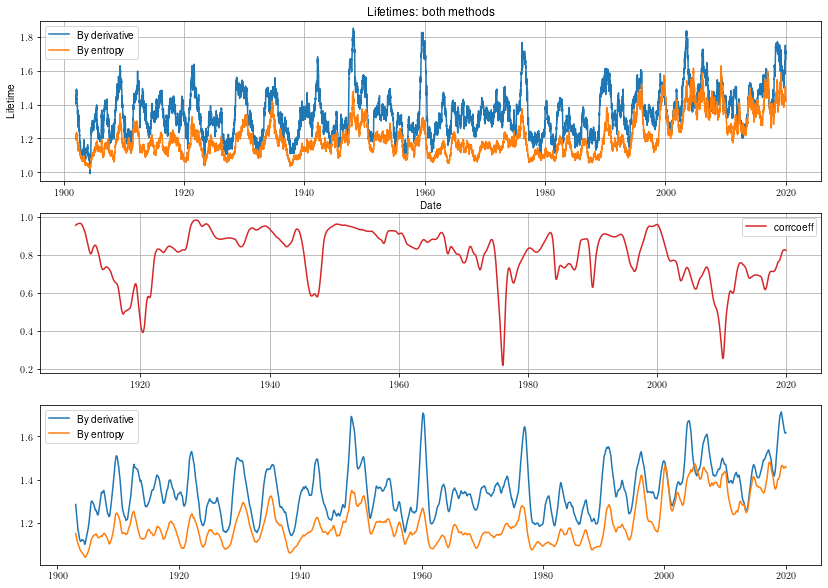

In [60]:
plot_all3(data_rel, window=365, corr_window=7*365)

In [61]:
SUNNY_THRESHOLD = 0.2
plot_all3(data_rel, window=365, corr_window=7*365)

In [ ]:
SUNNY_THRESHOLD = 0.2
plot_all3(data_rel, window=365, corr_window=7*365)

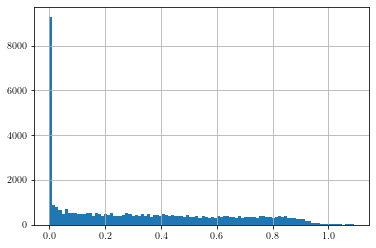

In [64]:
data_rel['val'].hist(bins=100)

In [66]:
data.loc[data['val'] != 0]['val'].hist(bins=100)

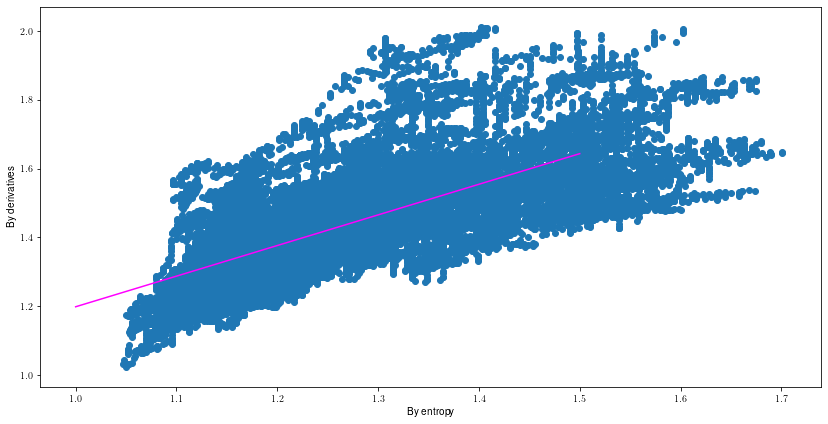

In [11]:
# threshold = 1
plot_all2(data, 365)

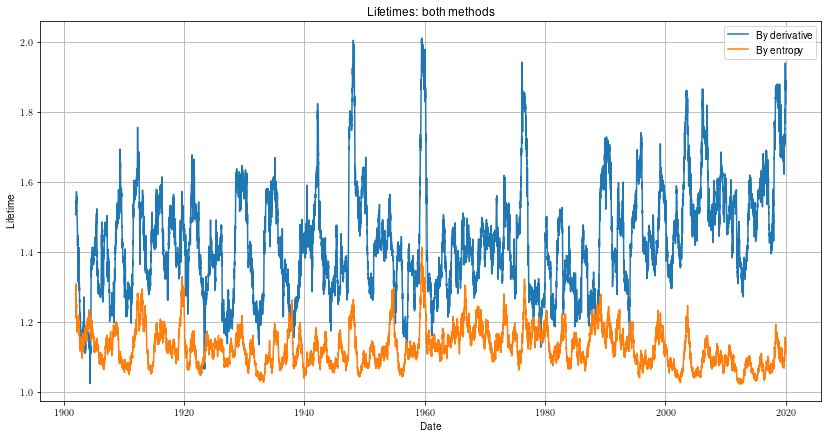

In [15]:
#threshold = global mean
plot_all(data, 365)

In [16]:
np.mean(data['val'])

4.291517652453038

In [178]:
plot_all(data, 365)

In [187]:
# threshold=3
plot_all(data, 365)

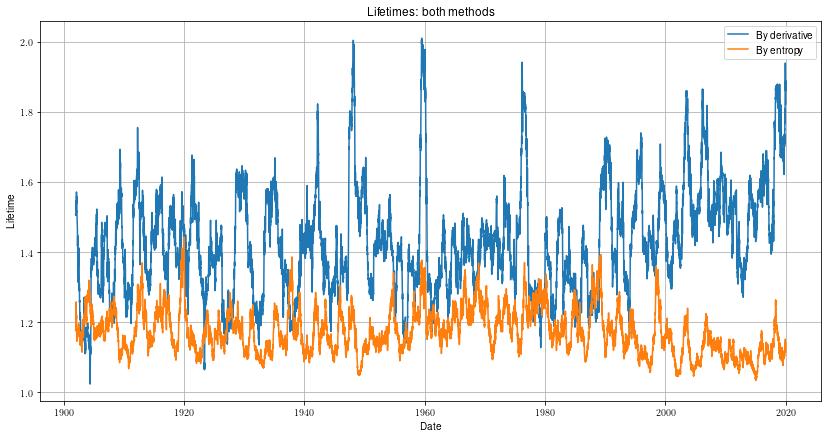

In [189]:
# threshold=5
plot_all(data, 365)

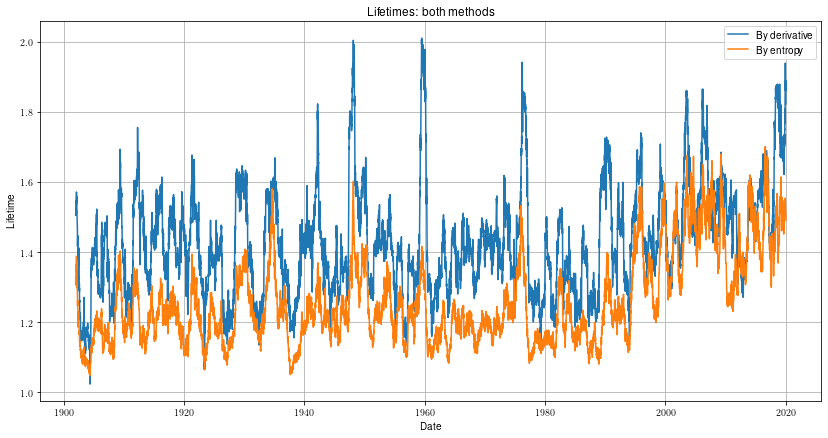

In [191]:
# threshold=1
plot_all(data, 365)

In [153]:
plot_lifetimes(data, 365)

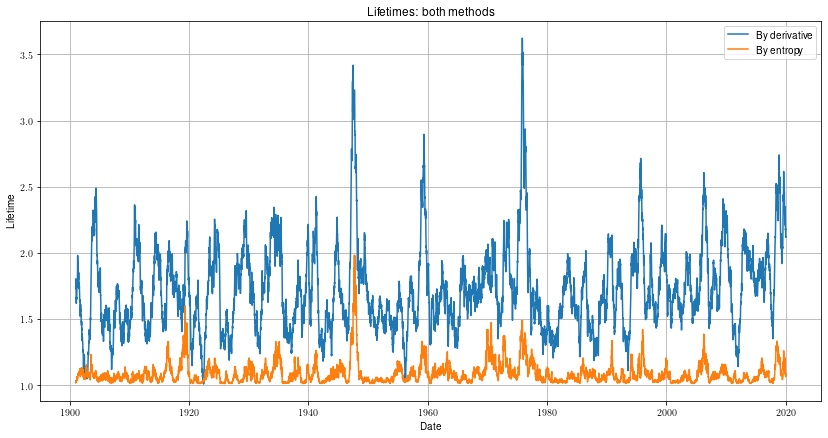

In [173]:
df = data[(data['month'] < 9) & (data['month'] > 5)].reset_index(drop=True)
plot_all(df, 90)

In [151]:
window = 365
dates = data.loc[window-1:, 'year'].tolist()
exp_entropys = get_exper_entropy(data['val'].tolist(), window)
dates = np.linspace(dates[0], dates[-1], len(exp_entropys))
epss = list(map(find_eps, exp_entropys))
lifetimes = list(map(lambda x : 1/x, epss))

plt.plot(dates, lifetimes)

Как можно выделить отдельные отрезки:
* Заменить все вне этих отрезков константой
* Заменить все вне этих отрезков сглаженными значениями (взять дней 10, например).
* Взять машинное обучение, натренировать модель на создание дней на основе только выбранного периода года. После чего нагенерить серию с помощью модели и прогнать стандартный алгоритм. Или можно просто посмотреть на коэффиценты в модели, если будет получаться прямая зависимость от предыдущих дней


<a id="method1"></a>
## Способ 1 : заменить на константу
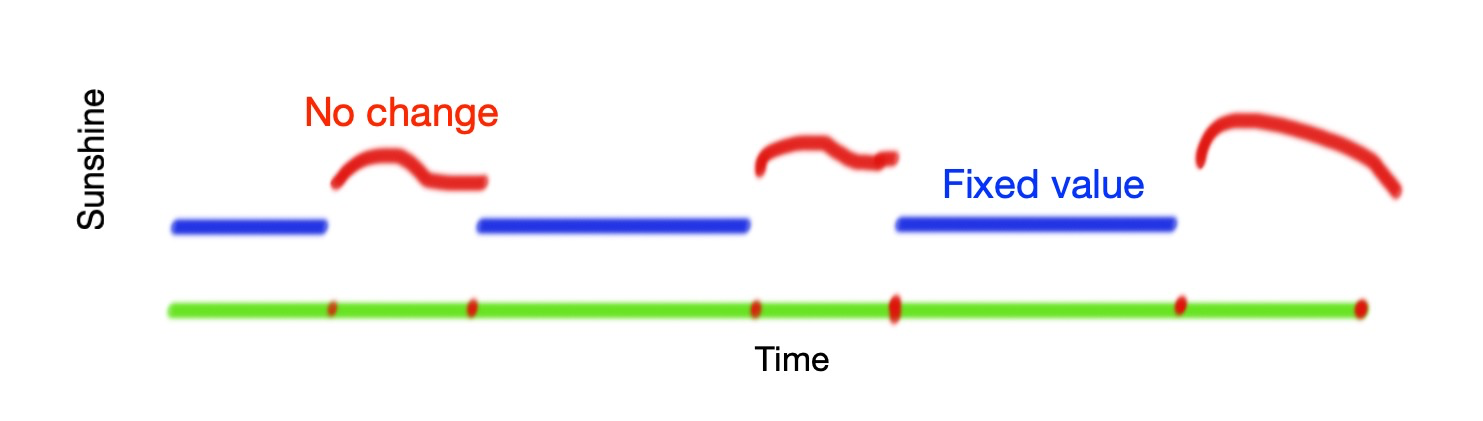

Понятно, что значения lifetime'а будет завышены. Но можно посмотреть, есть ли какая-то разница между отдельными сезонами.

Что видно:
* [зимой](#method1-winter) наблюдается небольшой спад в последние 40 лет в отличие от других сезонов
* по месяцам явных различий не видно. Если какие-то различия в уровне солнечности есть, то они связаны, скорее всего, с тем, что среднее значение, заполняющее бОльшую часть года, где-то больше, а где-то меньше.

[Содержание](#content)

In [9]:
# retrieves the period
def get_period(df, time_filter):
    df_copy = df.copy(deep=True)
    mean_ = np.mean(df_copy[time_filter(df_copy['month']) == False]['val'])
    print(mean_)
    df_copy.loc[time_filter(df['month']) == False, 'val'] = mean_
    return df_copy

def get_autumns(df):
    return get_period(df, lambda x : (8 < x) & (x < 12))

def get_summers(df):
    return get_period(df, lambda x : (5 < x) & (x < 9))

def get_winters(df):
    return get_period(df, lambda x : (x == 12) | ((0 < x) & (x < 3)))

def get_springs(df):
    return get_period(df, lambda x : (2 < x) & (x < 6))

def get_februaries(df):
    return get_period(df, lambda x : x == 2)

def get_marchs(df):
    return get_period(df, lambda x : x == 3)

def get_aprils(df):
    return get_period(df, lambda x : x == 4)

def get_mays(df):
    return get_period(df, lambda x : x == 5)

def get_junes(df):
    return get_period(df, lambda x : x == 6)

def get_julys(df):
    return get_period(df, lambda x : x == 7)

def get_augusts(df):
    return get_period(df, lambda x : x == 8)

def get_aprils(df):
    return get_period(df, lambda x : x == 9)

def get_octobers(df):
    return get_period(df, lambda x : x == 10)

def get_novembers(df):
    return get_period(df, lambda x : x == 11)

def get_decembers(df):
    return get_period(df, lambda x : x == 12)



<a id="method1-winter"></a>
### Зима

5.061560491119053


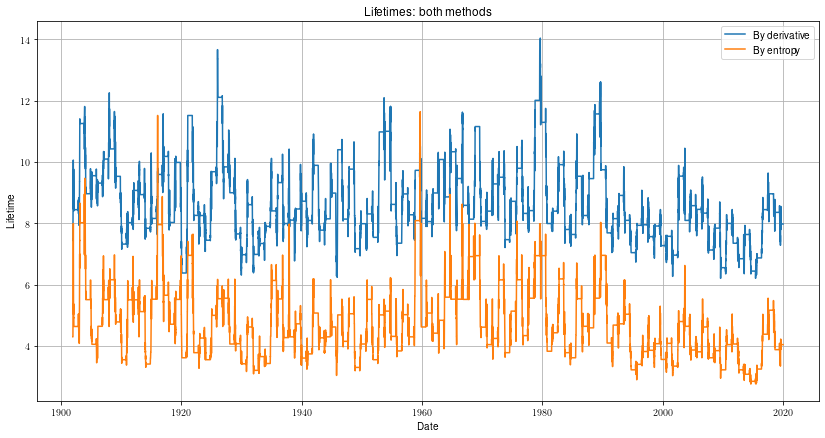

In [49]:
plot_all(get_winters(data), 365)

In [82]:
print(get_winters(data).shape)

5.061560491119053
(43620, 4)


5.061560491119053


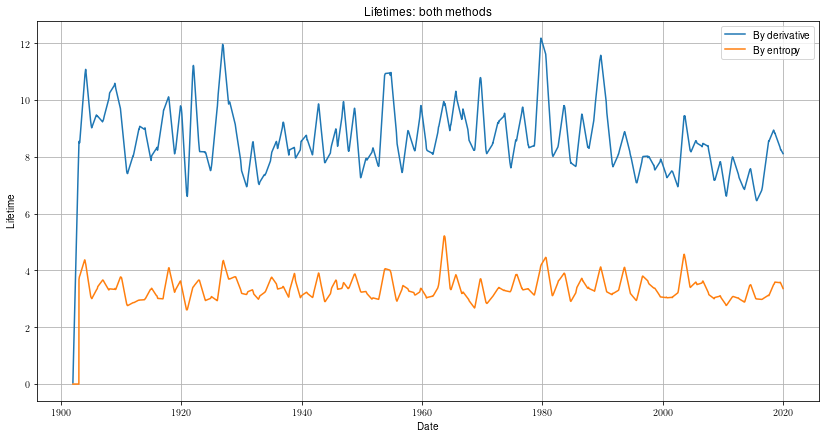

In [84]:
plot_all_means(get_winters(data), 365)

<a id="method2"></a>
## Способ 2 : сглаживание
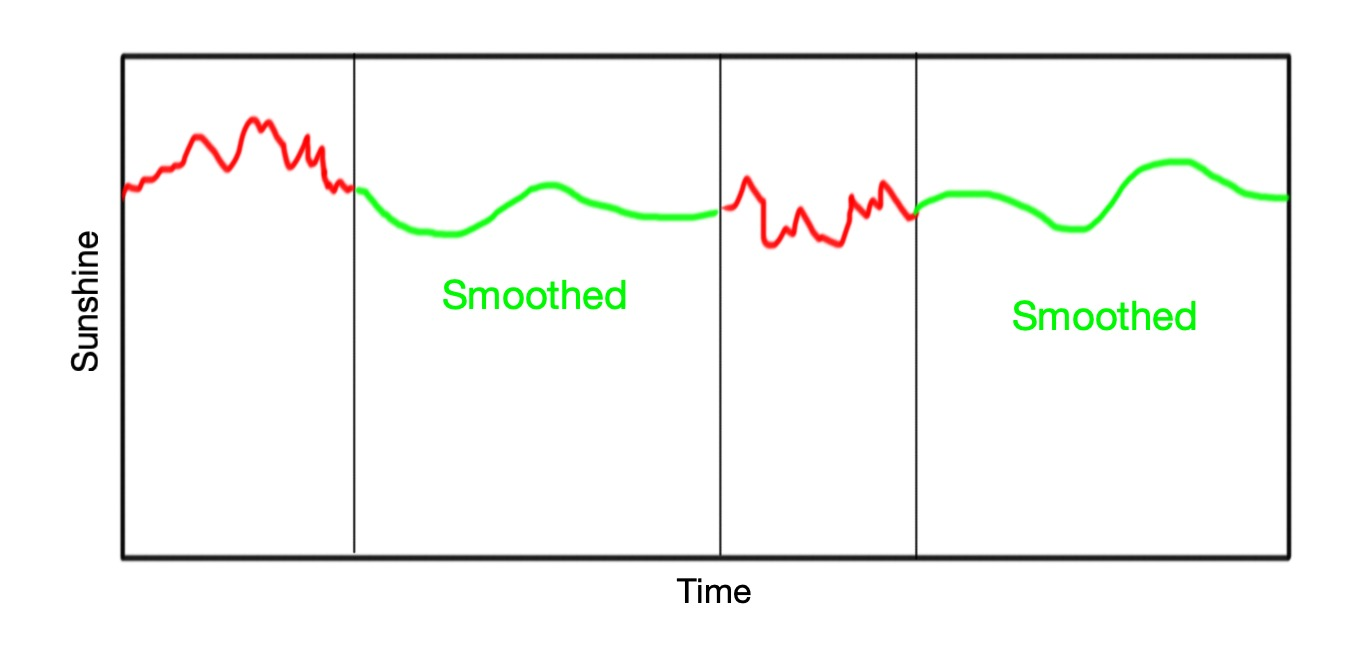
Интересный нам фрагмент оставляем без изменений. Все остальные значения заменяем средним в окне размером в $10$ дней (число взято пока что наугад). В предыдущем методе в качестве порогового значения в подсчете энтропии бралось глобальное среднее. Тут же возьмем в качестве порога $2$. ([изменить значения порога](#calc-mrc))

[Содержание](#content)

In [10]:
def get_smoothed(df, time_filter, window=5):
    df_copy = df.copy(deep=True)
    n = df_copy.shape[0]
    cursum = np.sum(df.loc[0: 2 * window - 1, 'val'])
    for i in range(window, n - window):
        if i % 1000 == 0:
            print('*', end='')
        cursum += df.at[i + window, 'val']
        if i > window:
            cursum -= df.at[i - window - 1, 'val']
        if not time_filter(df_copy.at[i, 'month']):
            df_copy.at[i, 'val'] = cursum / (2 * window + 1)
    print()
    return df_copy

def get_smoothed_winters(df, window=5):
    return get_smoothed(df, lambda x : x == 12 | (0 < x & x < 3), window)

def get_smoothed_springs(df, window=5):
    return get_smoothed(df, lambda x : (2 < x & x < 6), window)

def get_smoothed_summers(df, window=5):
    return get_smoothed(df, lambda x : (5 < x & x < 9), window)

def get_smoothed_autumns(df, window=5):
    return get_smoothed(df, lambda x : (8 < x & x < 12), window)

def get_smoothed_marchs(df, window=5):
    return get_smoothed(df, lambda x : (x == 3), window)

def get_smoothed_aprils(df, window=5):
    return get_smoothed(df, lambda x : (x == 4), window)

def get_smoothed_octobers(df, window=5):
    return get_smoothed(df, lambda x : (x == 10), window)






*******************************************


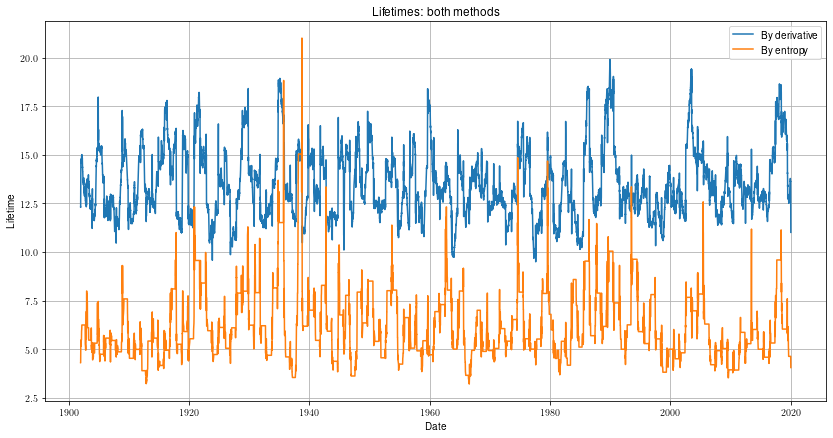

In [85]:
plot_all(get_smoothed_winters(data, window=10), 365)

*******************************************


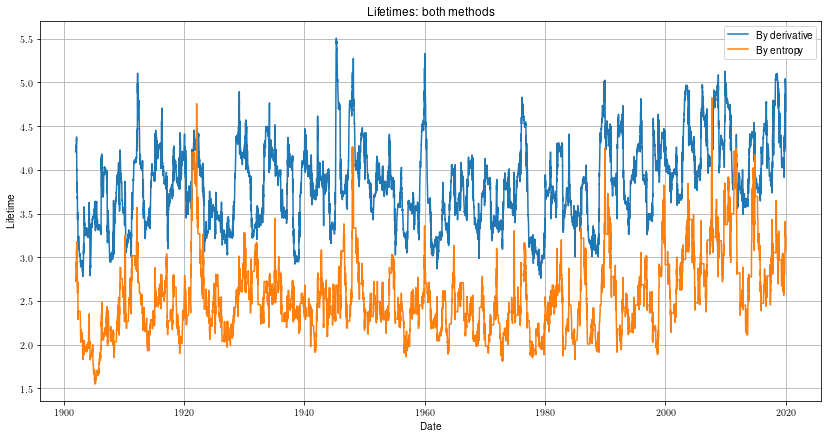

In [78]:
plot_all(get_smoothed_springs(data), 365)

*******************************************


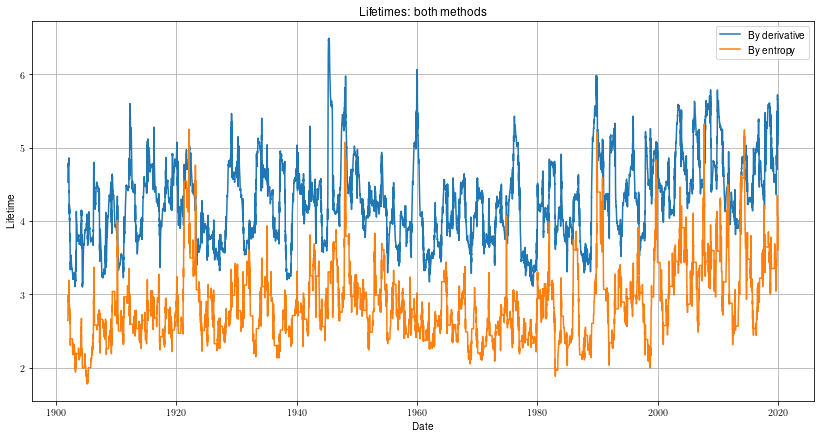

In [87]:
# window=10
plot_all(get_smoothed_springs(data, window=10), 365)

*******************************************


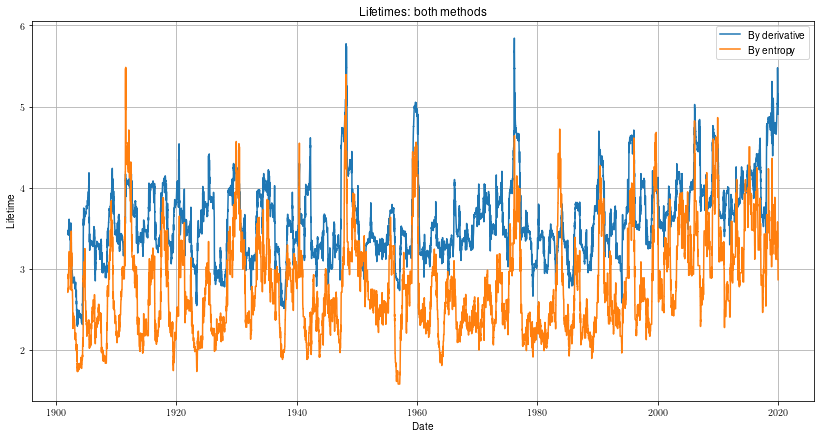

In [79]:
plot_all(get_smoothed_summers(data), 365)

*******************************************


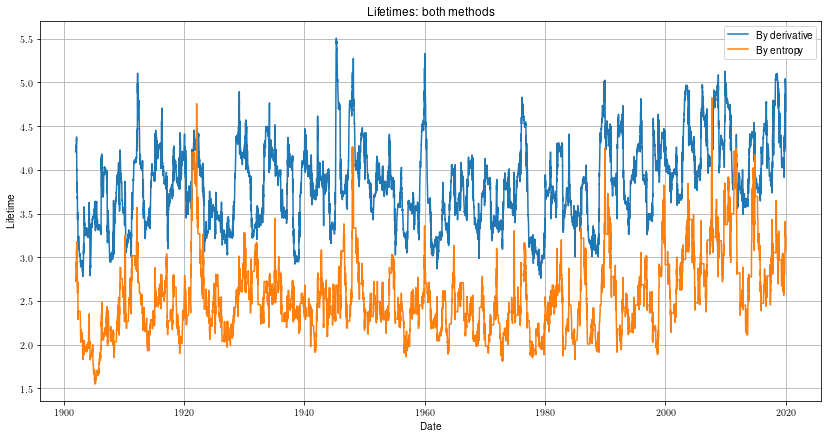

In [80]:
plot_all(get_smoothed_springs(data), 365)

*******************************************


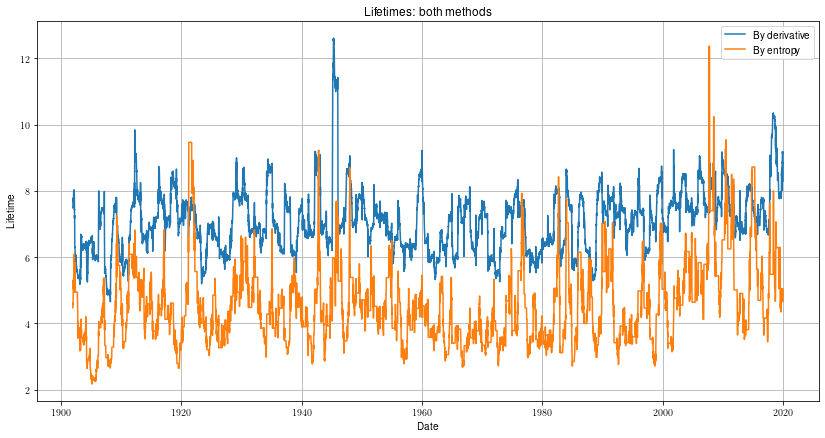

In [81]:
plot_all(get_smoothed_aprils(data), 365)

## Изменяем масштаб всего вне нужного отрезка


In [16]:
def rescale_outer(df, predicate, rescale):
    data = df.copy(deep=True)
    mask = predicate(df['month'])
    mask = np.array([1 if x else 0 for x in mask])
    new_val = np.array(df['val'])
    new_val = new_val * mask + new_val * rescale * (1 - mask)
    data['val'] = np.array(new_val)
    return data

## Заменяем все вне интервала слйчайным процессом

Делаем случайное блуждание, модулируем его синусом. Заменяем все между выделенными отрезками подобными последовательностями.

In [11]:
import random

def replace_with_noise(df, predicate):
    mask = predicate(df['month'])
    n = df.shape[0]
    new_val = np.array()
    
    
def random_walk(n):
    arr = []
    for i in range(n):
        if i == 0:
            arr.append(random.normalvariate(0, 1))
        else:
            arr.append(arr[-1] + random.normalvariate(0, 1))
    w = 2 * np.pi / 365
    plt.figure(figsize=(15, 7))
    plt.plot(arr, label='no modulation')
    for i in range(n):
        arr[i] *= np.sin(w * i)
    plt.plot(arr, label='with modulation')
    plt.legend()
    plt.grid(True)
    return arr



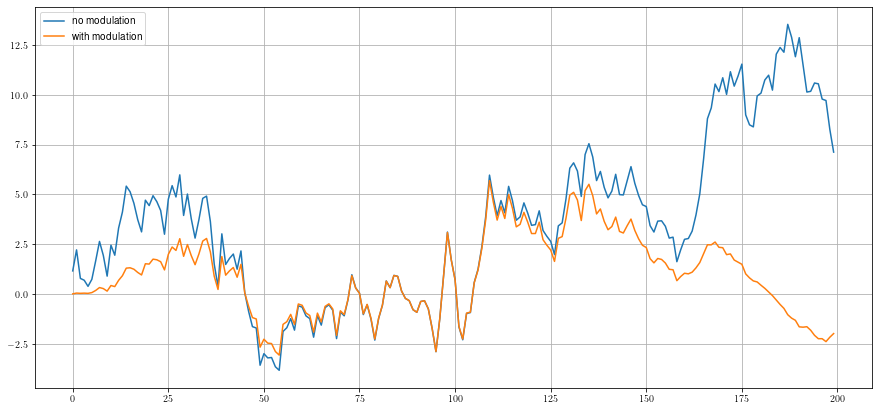

In [19]:
random_walk(200)

## Меняем подход

Теперь попробуем сначала считать меру, а только потом фильтровать нужный диапазон.

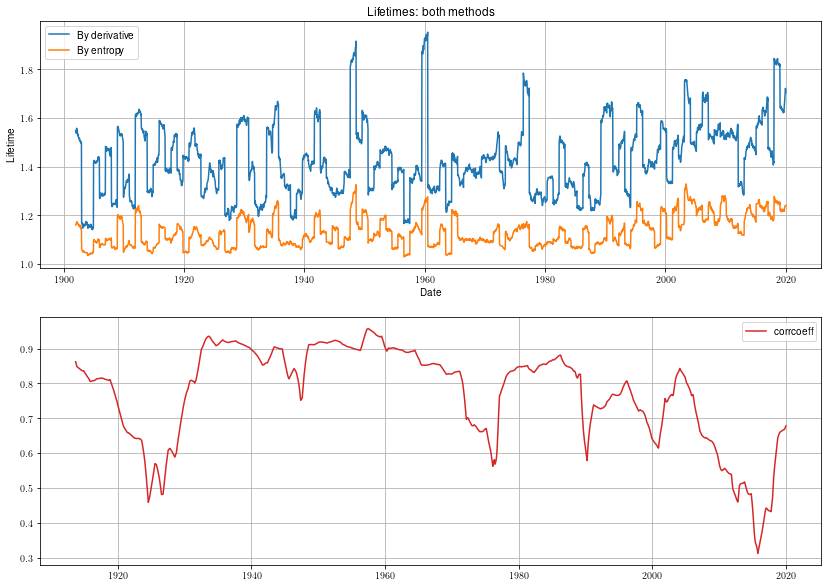

In [49]:
plot_all3(data, window=365, predicate=lambda month: month==3)

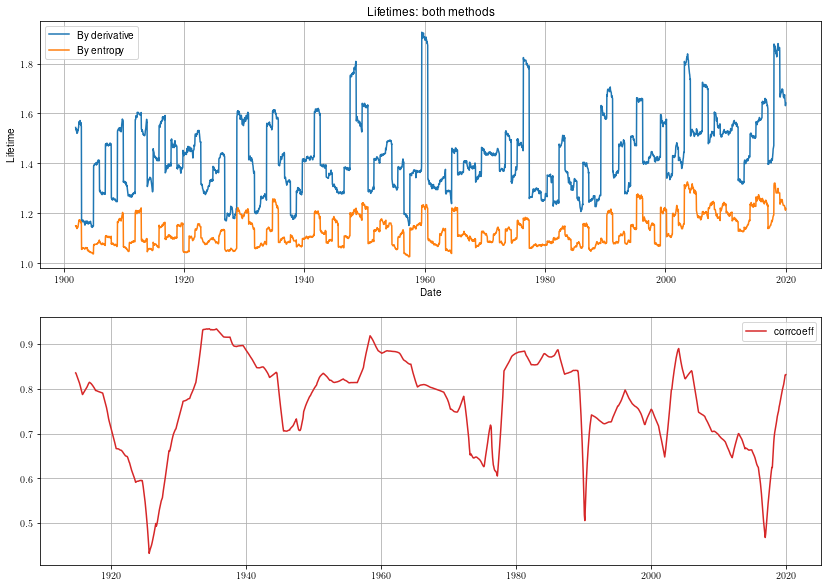

In [50]:
plot_all3(data, window=365, predicate=lambda month: month==2)

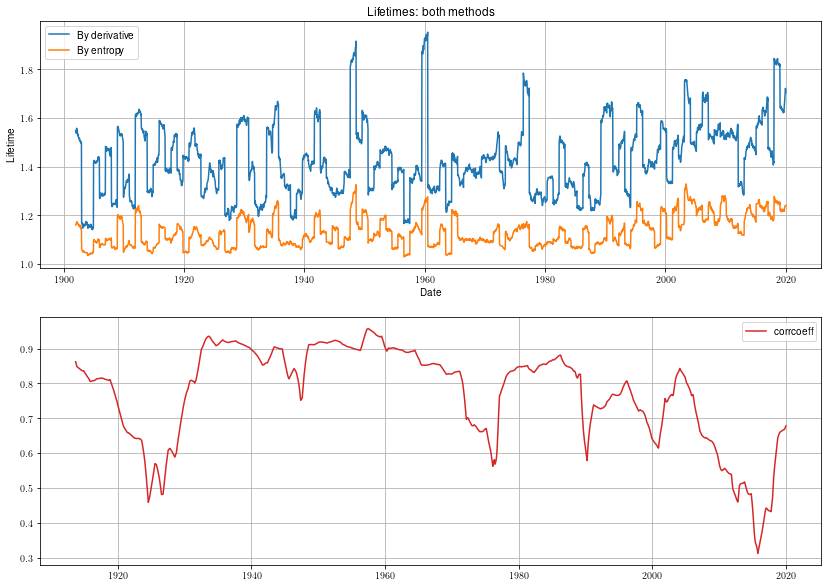

In [51]:
plot_all3(data, window=365, predicate=lambda month: month==3)

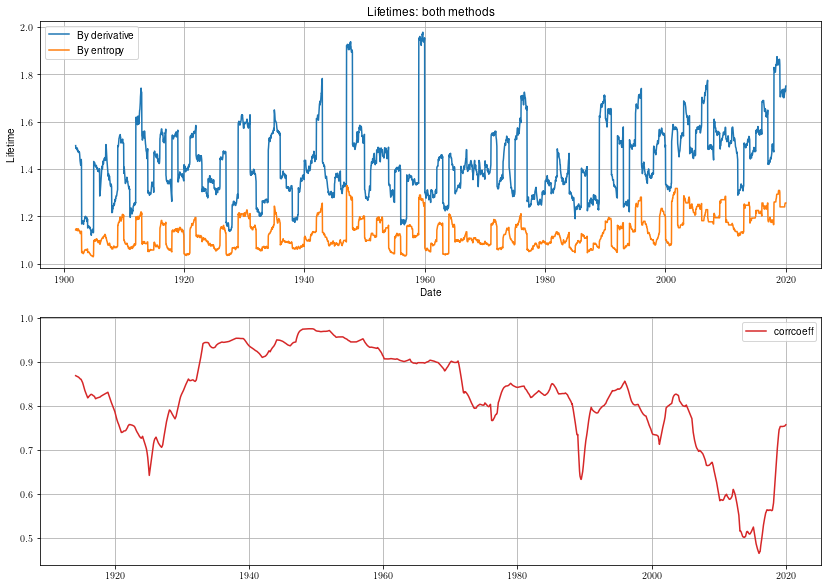

In [52]:
plot_all3(data, window=365, predicate=lambda month: month==4)

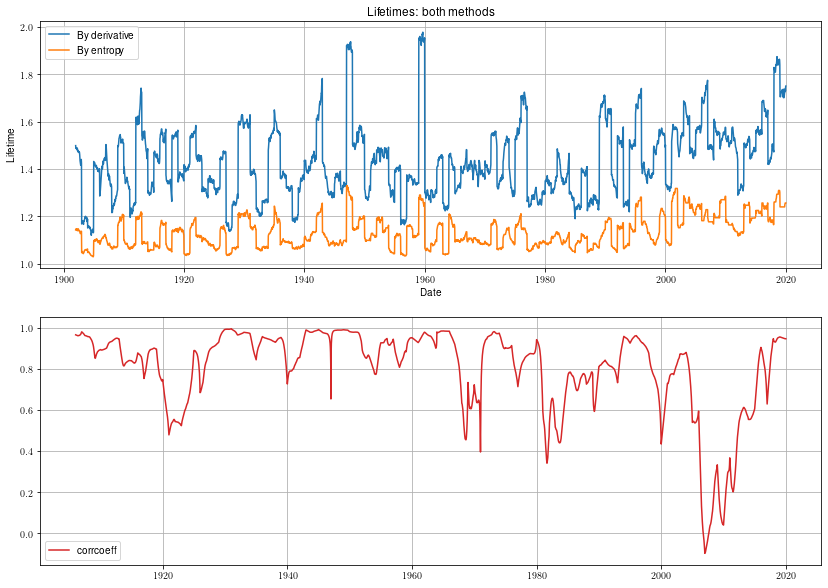

In [60]:
plot_all3(data, window=365, corr_window=120, predicate=lambda month: month==4)

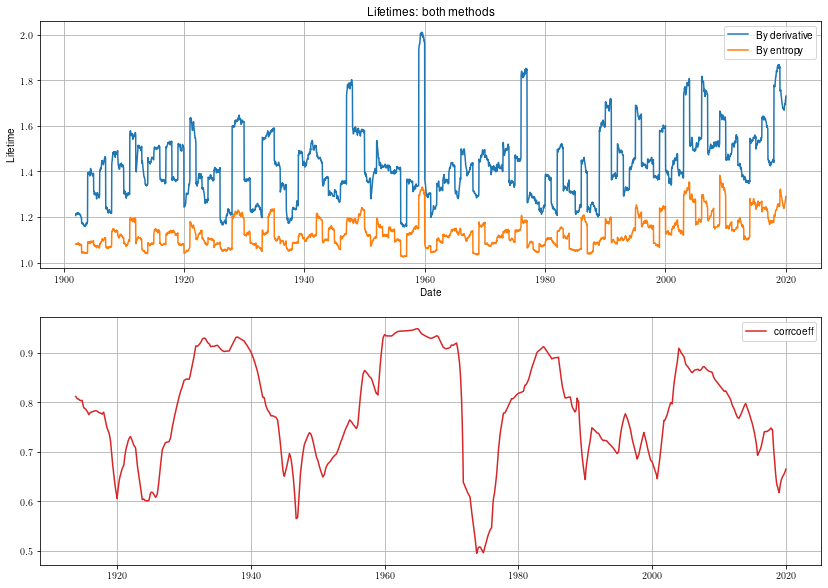

In [53]:
plot_all3(data, window=365, predicate=lambda month: month==10)

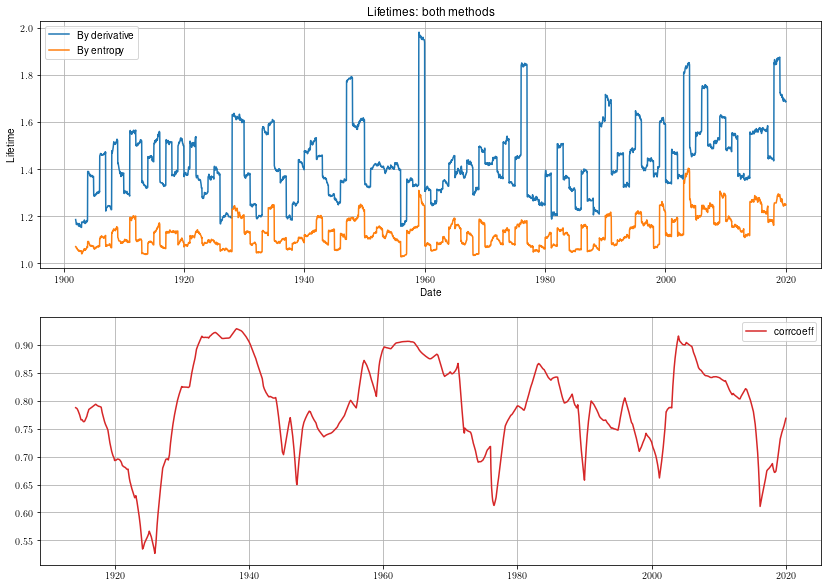

In [54]:
plot_all3(data, window=365, predicate=lambda month: month==11)

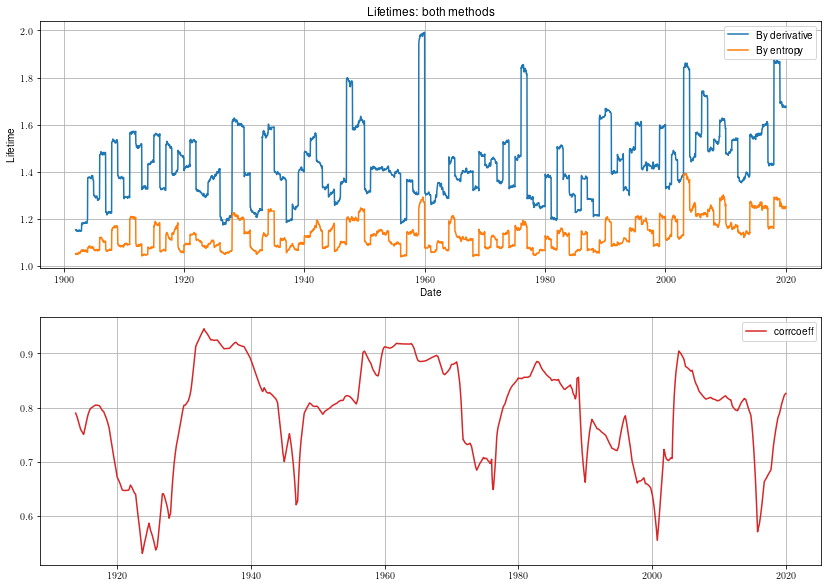

In [55]:
plot_all3(data, window=365, predicate=lambda month: month==12)

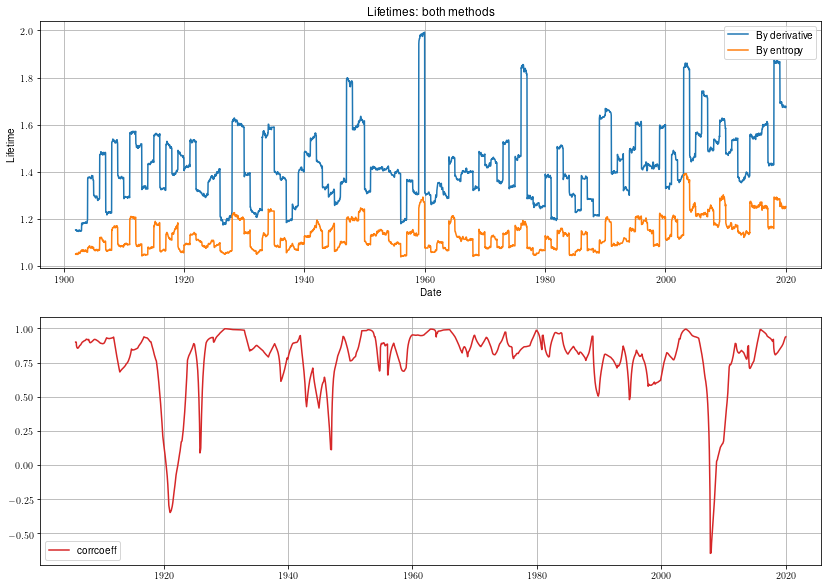

In [59]:
plot_all3(data, window=365, corr_window=120, predicate=lambda month: month==12)

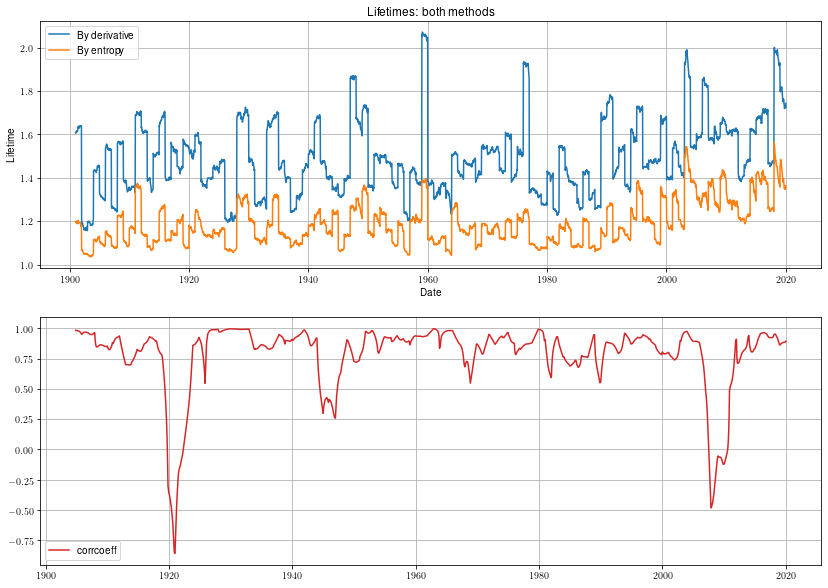

In [25]:
plot_all3(data, window=300, corr_window=120, predicate=lambda month: month==12)

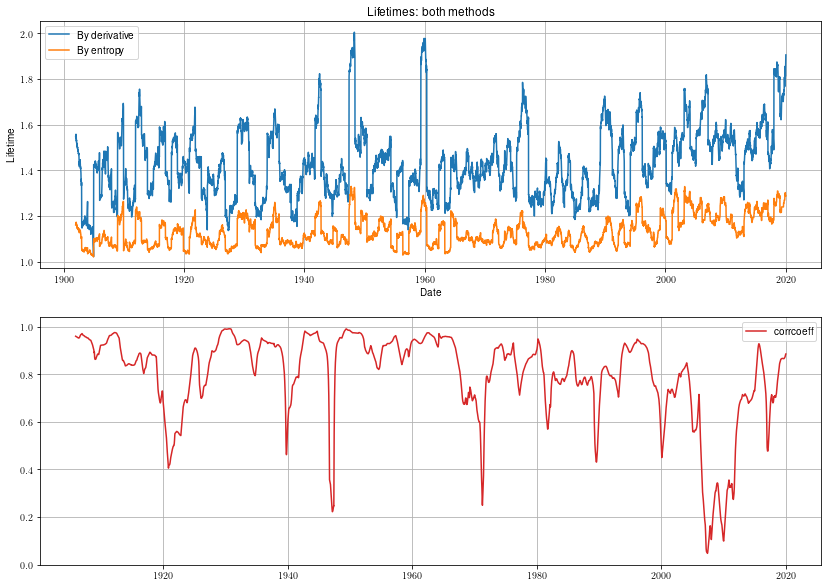

In [56]:
plot_all3(data, window=365, predicate=lambda month: (month>2) & (month<6))

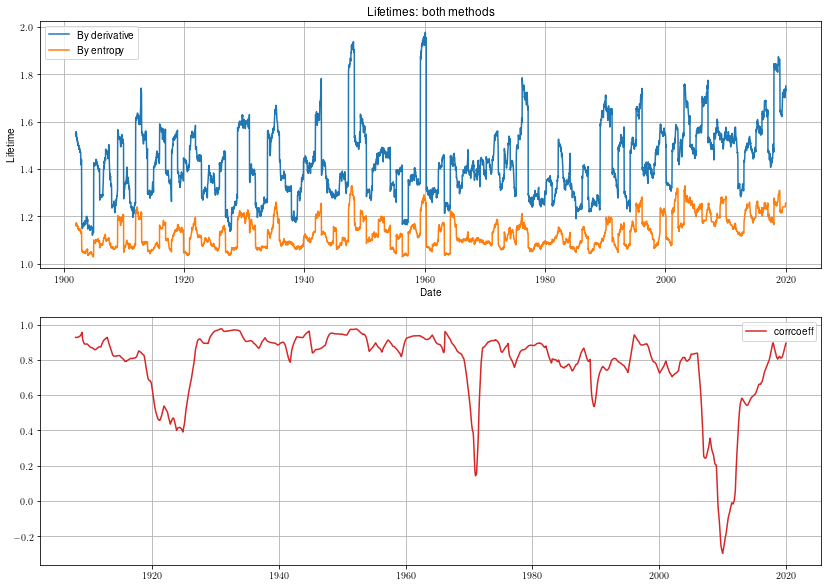

In [62]:
plot_all3(data, window=365, predicate=lambda month: (month>2) & (month<5))